# Toy example estimation of Radon-Nikodym derivative (one sided)

Equation (5) of the paper by Binkowski et al. explains that the Radon-Nikodym derivative $\frac{d \mathbb{Q}_y}{ \mathbb{P}_y^G}$ of the two domains exist under the assumptions they state. This derivative can also be seen as the ratio between the two distributions of the domains, and can be used to express the compensation for imbalance in the domains:

$\mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)] = \mathbb{E}_{X \sim \mathbb{P}_x}[D(G(X)) \frac{d \mathbb{Q}_y}{ d\mathbb{P}_y^G}(G(X))]$

This expresses compensation for imbalance between the discriminator outputs, caused by the imbalance in the domain distributions. However, it does not necessarily have to be used for the imbalance in the discriminator outputs. It can be applied to any imbalance caused by the different domain distributions.

The following toy example shows how we can use the Radon-Nikodym derivative for compensating the imbalance for the mean of the domains using $\bar{Y} = \bar{X}\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$.


Let $X = [1, 1, 1, 1, 1, 1, 1, 0, 0]$, with mean $\bar{X} = 0.8$ and <br />
Let $Y = [1, 1, 0, 0, 0, 0, 0, 0, 0]$, with mean $\bar{Y} = 0.2$

Then $0.2 = 0.8 \cdot \frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X)$, and <br />
$\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X) = \frac{0.2}{0.8} = 0.25$

This can be interpreted as the ratio between means of the domains being 0.25. In this example the ratio can be calculated. However, in more complex situations, for example with images, the Radon-Nykodym derivative $\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$ is unknown and we may try to estimate it using a neural network $W$. This leads to the objective function

$\inf_{W \in \mathcal{W}} (\mathbb{E}_{X \sim \mathbb{P}_x} [D(G(X)) \cdot W(X)] - \mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)])^2$

used by Binkowski et al. for compensation of distributions in the domains, using the discriminator output. Similarly, we can use such a network in our toy example.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

In [ ]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch.unsqueeze(1).unsqueeze(1).cpu(), nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0.5)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [ ]:
def binary_data(size=(2**21, 1), ratio=0.5):
    
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio

    image_batch = torch.zeros(size)
    image_batch[idx] = 1
    
    return image_batch.clamp(0, 1).cuda().detach()

In [ ]:
class ColorDataset(Dataset):
    '''The dataloader for the binary data
    '''
    def __init__(self, ratio=0.5):

        self.ratio = ratio
        
        self.dataset = binary_data(ratio=self.ratio)
        
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 1))
        example_imgs[1] = 1
        
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

In [ ]:
# Settings for domain A (red)
ratio_A = 0.2
dataset_A = ColorDataset(ratio=ratio_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
ratio_B = 0.8
dataset_B = ColorDataset(ratio=ratio_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

In [ ]:
import cv2

def plot_hist(data):
    data = data.squeeze().cpu()
    plt.hist(data[data==1], weights=torch.ones(len(data[data==1]))/len(data), 
             color='black', bins=10, range= (0, 1))
    plt.hist(data[data==0], weights=torch.ones(len(data[data==0]))/len(data), 
             color='white', bins=10, range= (0, 1))
    plt.gca().set_facecolor('xkcd:gray')
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print(len(data_A))
    plot_hist(data_A)
    plot_hist(data_B)
    
    visualize_img_batch(data_A[:64])
    visualize_img_batch(data_B[:64])
    break

In [ ]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        out = self.fc2(h1)
        return self.softmax(out)
#         return out

In [8]:
# Initialize the networks
weight_network = WeightNet().cuda()

# Initialize the optimizers
lr = 0.01
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

losses_w = []

mean_A = []
mean_B = []

L_As = []
L_Bs = []

example_importances_A = []
example_importances_B = []

def weight_normalization(w):
    return w
#     return 0.5*(1 + w)

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
#         real_A = torch.Tensor([1,1,0,0,0,0,0,0,0,0]).cuda().view(-1, 1).detach()
#         real_B = torch.Tensor([1,1,1,1,1,1,1,1,0,0]).cuda().view(-1, 1).detach()

        # The weighting process
        w = weight_network(real_A)
    
        # The loss function --------------------------------------------------------------------------------
        
        # Using the means as objective function
        L_A  = (real_A * weight_normalization(w)).sum()
        L_B = (real_B).mean()
        loss_w = (L_A - L_B)**2
        
        mean_A += [real_A.mean()]
        mean_B += [real_B.mean()]

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()   

        # Store values --------------------------------------------------------------------------------------
        L_As += [L_A.item()]
        L_Bs += [L_B.item()]
        
        losses_w += [loss_w.item()]
        
        w_a = weight_normalization((weight_network(dataset_A.example_imgs.view(-1,1).cuda())))
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            print('step', i, 'loss_w: ', loss_w.item())
            
        if i % 5000 == 0 and i != 0:
            break

step 0 loss_w:  0.3611093759536743
step 500 loss_w:  1.5905314285191707e-05
step 1000 loss_w:  0.004487358964979649
step 1500 loss_w:  0.00029524340061470866
step 2000 loss_w:  0.0016566321719437838
step 2500 loss_w:  0.0004355855053290725
step 3000 loss_w:  0.001877262839116156
step 3500 loss_w:  1.0900697816396132e-05
step 4000 loss_w:  0.0023051996249705553
step 4500 loss_w:  1.1077736417064443e-07
step 5000 loss_w:  0.0024122893810272217


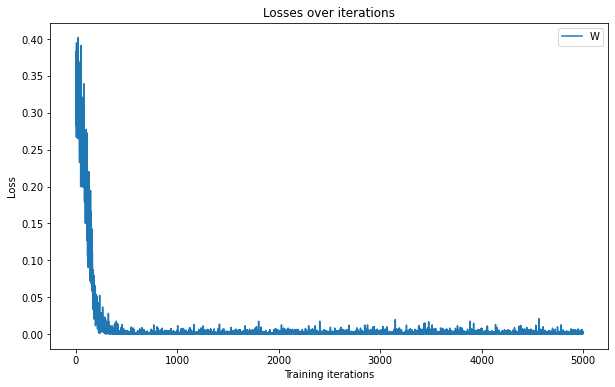

In [9]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

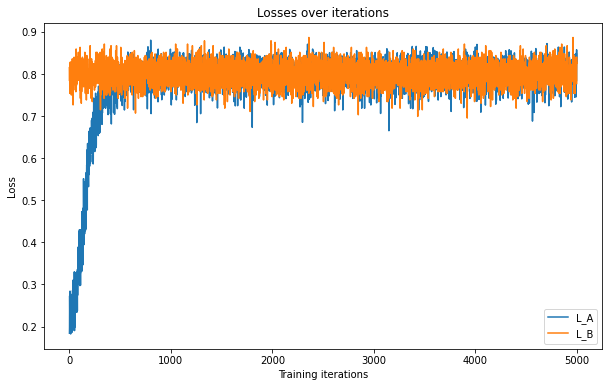

In [10]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(L_As)
plt.plot(L_Bs)
plt.legend(['L_A', 'L_B'])
plt.show()

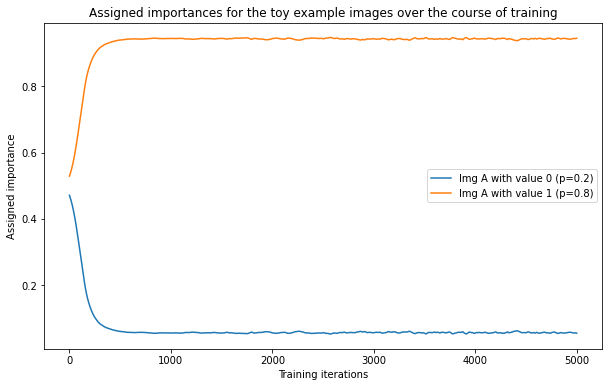

(0.05550006031990051, 0.9444999098777771)

In [11]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.legend(['Img A with value {} (p={})'.format(0, ratio_A), 
            'Img A with value {} (p={})'.format(1, 1-ratio_A)])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

example_importances_A[-1]

In [12]:
a = example_importances_A[-1][0]
b = example_importances_A[-1][1]
a, b

(0.05550006031990051, 0.9444999098777771)

In [13]:
# We find that the ratio is equal
a/b, 0.25/4.0

(0.0587613188095301, 0.0625)

In [14]:
print(ratio_A/ratio_B)
print(ratio_B/ratio_A)

0.25
4.0


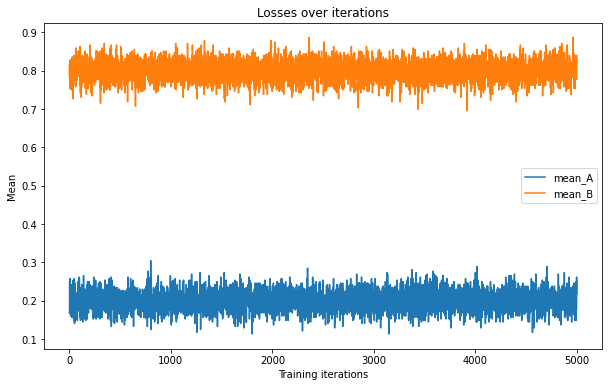

In [15]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Mean')
plt.plot(mean_A)
plt.plot(mean_B)
plt.legend(['mean_A', 'mean_B'])
plt.show()